## Data: [FRAP Fire Perimeters](https://frap.fire.ca.gov/frap-projects/fire-perimeters/)
    "The fire perimeter database represents the most complete digital record of fire perimeters in California. However it is still incomplete in many respects." 
### Caution: 
    Fires may be missing altogether or have missing or incorrect attribute data. 
    
    Some fires may be missing because historical records were lost or damaged, fires were too small for the minimum cutoffs, documentation was inadequate, or fire perimeters have not yet been incorporated into the database.
    
    While the data capture process attempts to identify duplicate fires resulting from multiple data sources (i.e. the USFS and CAL FIRE both captured and submitted the fire perimeter), some duplicates may still exist.
    
### History: 
    The data covered the period 1950 to 2001 and included USFS wildland fires 10 acres and greater, and CAL FIRE fires 300 acres and greater. BLM and NPS joined the effort in 2002, collecting fires 10 acres and greater.
    
    In 1989... FRAP provided... a preliminary map of 1950-89 fire perimeters. Unit personnel also verified the pre-1989 perimeter maps... Each CAL FIRE Unit then generated a list of 300+ acre fires that started since 1989 using the CAL FIRE Emergency Activity Reporting System (EARS). The CAL FIRE personnel used this list to gather post-1989 perimeter maps for digitizing. 
    
    The final product is a statewide GIS layer spanning the period 1950-1999.

### Update Process: 
    Fires from the latest fire year will be uploaded to the database once annually
    
### Note: 
    CAL FIRE has completed inventory for the majority of its historical perimeters back to 1950. BLM fire perimeters are complete from 2002 to the present. The USFS has submitted records as far back as 1878. The NPS records date to 1921.
    
**We will omit fires before 1950**

### Download Data

In [1]:
!pip install wget
!mkdir -p ./data
import wget 
import zipfile

# FRAP Fire Perimeters
# wget.download('https://frap.fire.ca.gov/media/3nrpp42r/fire20_1.zip', './data/fire_perimeters_CA.zip')
# with zipfile.ZipFile('./data/fire_perimeters_CA.zip', 'r') as zip_ref:
#     zip_ref.extractall(r"./data")
# !rm -f ./data/fire_perimeters_CA.zip # don't need the zip file anymore

#### Additional data files ([GIS Data](https://frap.fire.ca.gov/mapping/gis-data/))

In [33]:
# # County Boundaries
# wget.download('https://frap.fire.ca.gov/media/2521/cnty19_1.zip', './data/counties.zip')
# with zipfile.ZipFile('./data/counties.zip', 'r') as zip_ref:
#     zip_ref.extractall(r"./data")
# !rm -f ./data/counties.zip # don't need the zip file anymore

# # Incorporated Cities
# wget.download('https://frap.fire.ca.gov/media/uskm2rsi/incorp21_2.zip', './data/incorp_cities.zip')
# with zipfile.ZipFile('./data/incorp_cities.zip', 'r') as zip_ref:
#     zip_ref.extractall(r"./data")
# !rm -f ./data/incorp_cities.zip
    
# ADD MORE DATA FILES AS DESIRED; Use above format
temp = 'https://frap.fire.ca.gov/media/10091/pl_reducewildfirethreattocommunities18_1.zip'
wget.download(temp, './data/temp.zip')
with zipfile.ZipFile('./data/temp.zip', 'r') as zip_ref: 
    zip_ref.extractall(r"./data")
!rm -f ./data/temp.zip

### Imports

In [3]:
import pandas as pd
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt

## Load Data

In [2]:
FIRE_PERIMS_PATH = './data/fire20_1.gdb'
INCORP_CITIES_PATH = './data/incorp21_2.gdb'
COUNTIES_PATH = './data/cnty19_1.gdb'

print(fiona.listlayers(FIRE_PERIMS_PATH))
print()
print(fiona.listlayers(INCORP_CITIES_PATH))
print()
print(fiona.listlayers(COUNTIES_PATH))

['firep20_1', 'rxburn20_1', 'Non_RXFire_Legacy13_2']

['incorp21_2']

['cnty19_1_full', 'cnty19_1_basic', 'cntrystate19_1_all', 'cntrystate19_1_neighbor', 'state19_1', 'ocean19_1', 'cnty19_1_basicplus', 'cnty19_1_basicplus_line']


In [34]:
TEMP_PATH = './data/'
print(fiona.listlayers(TEMP_PATH))

[]


In [39]:
!ogrinfo -so -al ./data/ca_data/cnty19_1.gdb

INFO: Open of `./data/ca_data/cnty19_1.gdb'
      using driver `OpenFileGDB' successful.

Layer name: cnty19_1_full
Geometry: Multi Polygon
Feature Count: 10798
Extent: (-374980.543100, -604495.794300) - (540082.750000, 450023.161800)
Layer SRS WKT:
PROJCRS["NAD83 / California Albers",
    BASEGEOGCRS["NAD83",
        DATUM["North American Datum 1983",
            ELLIPSOID["GRS 1980",6378137,298.257222101,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4269]],
    CONVERSION["California Albers",
        METHOD["Albers Equal Area",
            ID["EPSG",9822]],
        PARAMETER["Latitude of false origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8821]],
        PARAMETER["Longitude of false origin",-120,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8822]],
        PARAMETER["Latitude of 1st standard parallel",34,
            ANG

In [28]:
temp = gpd.read_file(TEMP_PATH)

ValueError: Null layer: ''

In [24]:
print(temp.shape)
temp.columns

(1255, 16)


Index(['NAME', 'CAD_NAME', 'AKA', 'TYPE', 'UNIT', 'COUNTY', 'OWNER', 'FUNDING',
       'STAFFING', 'ADDRESS', 'CITY', 'ZIP', 'PHONE_NUM', 'LAT', 'LON',
       'geometry'],
      dtype='object')

<AxesSubplot:>

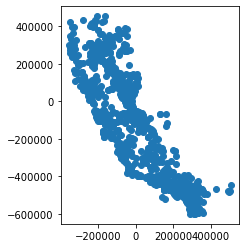

In [25]:
temp.plot()

#### Fire Perimeters data (~50MB)

In [3]:
# A layer depicting wildfire perimeters from contributing agencies current as of the previous fire year
calfires_df = gpd.read_file(FIRE_PERIMS_PATH, layer=0)
# columns to drop initially
dropped_cols = ['AGENCY', 'UNIT_ID', 'FIRE_NAME', 'COMMENTS', 'FIRE_NUM', 'STATE', 'INC_NUM']
extra_cols = ['REPORT_AC', 'C_METHOD'] # potentially drop later; leave for now
calfires_df.drop(columns=dropped_cols, inplace=True)

# A layer depicting prescribed fires supplied from contributing agencies current as of the previous fire year
pfires_df = gpd.read_file(FIRE_PERIMS_PATH, layer=1)

# A layer representing non-prescribed fire fuel reduction projects that were initially included in the fires_dfbase
npfires_df = gpd.read_file(FIRE_PERIMS_PATH, layer=2)

In [11]:
pfires_df

,YEAR_,STATE,AGENCY,UNIT_ID,TREATMENT_ID,TREATMENT_NAME,TREATMENT_TYPE,START_DATE,END_DATE,TREATED_AC,GIS_ACRES,RX_CONSUM,PRE_CON_CLASS,POST_CON_CLASS,Shape_Length,Shape_Area,geometry
0,2020,CA,CDF,AEU,10509,Jan 31 2020 Broadcast,3.0,2020-01-31T00:00:00+00:00,2020-01-31T00:00:00+00:00,15.0,15.047045,NaN,NaN,NaN,1365.887529,6.089322e+04,"MULTIPOLYGON (((-45261.902 81865.442, -45248.3..."
1,2020,CA,PVT,AEU,10572,2020 Fuels Reduction,3.0,2020-02-13T00:00:00+00:00,2020-02-13T00:00:00+00:00,22.3,36.739716,NaN,NaN,NaN,2681.610336,1.486803e+05,"MULTIPOLYGON (((-57222.192 98500.043, -57231.6..."
2,2020,CA,CDF,AEU,10630,Feb 2020 Broadcast,3.0,2020-02-13T00:00:00+00:00,2020-02-18T00:00:00+00:00,22.4,38.839848,NaN,NaN,NaN,3918.219956,1.571792e+05,"MULTIPOLYGON (((-49821.237 54143.575, -49815.4..."
3,2020,CA,CDF,AEU,10639,Feb 2020 Broadcast,3.0,2020-02-11T00:00:00+00:00,2020-02-20T00:00:00+00:00,75.5,75.502464,NaN,NaN,NaN,3918.834462,3.055300e+05,"MULTIPOLYGON (((-47052.539 80922.773, -47052.5..."
4,2020,CA,CDF,AEU,10780,Mar 3 2020 Broadcast,3.0,2020-03-03T00:00:00+00:00,2020-03-03T00:00:00+00:00,61.8,61.773609,NaN,NaN,NaN,2769.034316,2.499805e+05,"MULTIPOLYGON (((-47591.189 80696.956, -47590.2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6407,2019,CA,CDF,BEU,9011,Rock Springs VMP,3.0,2019-06-17T00:00:00+00:00,2019-06-17T00:00:00+00:00,6.0,4410.436035,NaN,NaN,NaN,43918.799708,1.784839e+07,"MULTIPOLYGON (((-83812.469 -167644.628, -83812..."
6408,2019,CA,CDF,BEU,9011,Rock Springs VMP,3.0,2019-11-14T00:00:00+00:00,2019-11-19T00:00:00+00:00,4404.0,4410.436035,NaN,NaN,NaN,43918.799708,1.784839e+07,"MULTIPOLYGON (((-83812.469 -167644.628, -83812..."
6409,2019,CA,OTH,BEU,9874,Impact Burn,3.0,2019-05-01T00:00:00+00:00,2019-06-01T00:00:00+00:00,1728.0,1728.423584,NaN,NaN,NaN,12837.895799,6.994679e+06,"MULTIPOLYGON (((-68525.876 -241585.362, -68522..."
6410,2019,CA,CDF,SLU,10270,Webster Burning,3.0,2019-11-12T00:00:00+00:00,2019-12-31T00:00:00+00:00,131.0,131.035889,NaN,NaN,NaN,6110.293336,5.302832e+05,"MULTIPOLYGON (((-48329.776 -282952.083, -48320..."


In [4]:
calfires_df

,YEAR_,ALARM_DATE,CONT_DATE,CAUSE,REPORT_AC,GIS_ACRES,C_METHOD,OBJECTIVE,Shape_Length,Shape_Area,geometry
0,2020,2020-06-18T00:00:00+00:00,2020-06-23T00:00:00+00:00,11.0,110.0,109.602501,1.0,1.0,3252.523280,4.435447e+05,"MULTIPOLYGON (((-116841.251 97942.565, -116836..."
1,2020,2020-06-01T00:00:00+00:00,2020-06-04T00:00:00+00:00,2.0,670.0,685.585022,1.0,1.0,9653.760308,2.774464e+06,"MULTIPOLYGON (((-117328.400 90212.407, -117321..."
2,2020,2020-08-10T00:00:00+00:00,2020-03-01T00:00:00+00:00,14.0,26.0,27.300480,1.0,1.0,1649.643235,1.104811e+05,"MULTIPOLYGON (((-115605.059 92988.787, -115585..."
3,2020,2020-03-31T00:00:00+00:00,2020-04-01T00:00:00+00:00,9.0,13.0,12.931550,1.0,1.0,1577.155857,5.233211e+04,"MULTIPOLYGON (((-110213.270 105975.579, -11020..."
4,2020,2020-04-14T00:00:00+00:00,2020-04-19T00:00:00+00:00,18.0,10.3,10.315960,1.0,1.0,1035.787625,4.174722e+04,"MULTIPOLYGON (((-111793.600 164243.615, -11177..."
...,...,...,...,...,...,...,...,...,...,...,...
21313,2019,2019-10-30T00:00:00+00:00,2019-10-30T00:00:00+00:00,NaN,NaN,6.297734,NaN,1.0,741.886109,2.548602e+04,"MULTIPOLYGON (((122180.088 -428557.696, 122181..."
21314,2019,2019-10-28T00:00:00+00:00,2019-10-28T00:00:00+00:00,14.0,NaN,8.482671,8.0,1.0,1004.069271,3.432815e+04,"MULTIPOLYGON (((120221.043 -428836.863, 120220..."
21315,2019,2019-11-09T00:00:00+00:00,2019-11-10T00:00:00+00:00,14.0,NaN,64.888229,8.0,1.0,3383.890106,2.625933e+05,"MULTIPOLYGON (((153212.742 -428811.823, 153216..."
21316,2019,None,None,14.0,NaN,66.587181,8.0,1.0,3897.065019,2.694688e+05,"MULTIPOLYGON (((409025.711 -295687.235, 409021..."


#### Counties data (~50MB)
Notice that we have 7 different layers available

layer # is 0


<Figure size 432x288 with 0 Axes>

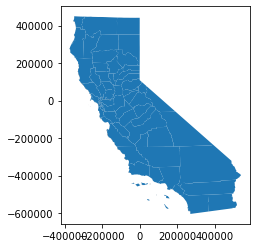

layer # is 1


<Figure size 432x288 with 0 Axes>

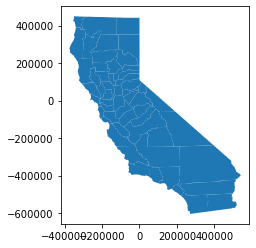

layer # is 2


<Figure size 432x288 with 0 Axes>

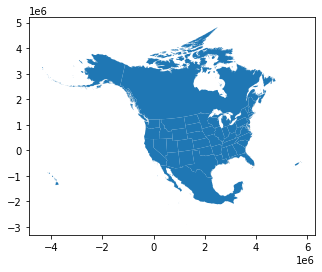

layer # is 3


<Figure size 432x288 with 0 Axes>

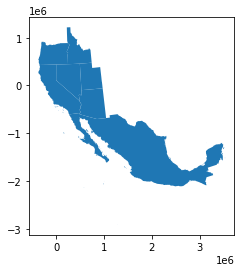

layer # is 4


<Figure size 432x288 with 0 Axes>

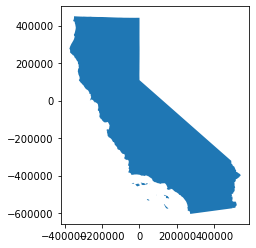

layer # is 5


<Figure size 432x288 with 0 Axes>

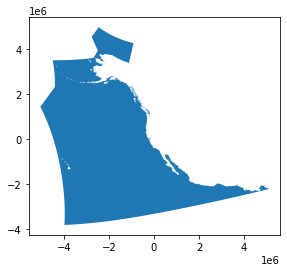

layer # is 6


<Figure size 432x288 with 0 Axes>

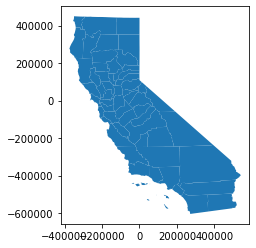

layer # is 7


<Figure size 432x288 with 0 Axes>

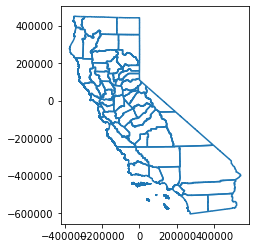

In [5]:
# plot each layer to get some intuition about what layers to use
for i in range(8): 
    print(f"layer # is {i}")
    fig = plt.figure(i)
    counties_df = gpd.read_file(COUNTIES_PATH, layer=i)
    counties_df.plot()
    plt.show()

In [6]:
counties_df = gpd.read_file(COUNTIES_PATH, layer=7)
counties_df.COUNTY_NAME.nunique()
counties_df

,FID_cnty18_1_basicplus,COUNTY_NAME,COUNTY_ABBREV,COUNTY_NUM,COUNTY_CODE,COUNTY_FIPS,Shape_Length,ISLAND,geometry
0,68,Los Angeles,LOS,19,19,037,113390.846736,Channel Islands,"MULTILINESTRING ((136720.343 -558176.528, 1367..."
1,64,Ventura,VEN,56,56,111,59953.208117,Channel Islands,"MULTILINESTRING ((51561.856 -532515.409, 51552..."
2,37,San Diego,SDG,37,37,073,224203.299418,None,"MULTILINESTRING ((365906.750 -591772.062, 3627..."
3,59,Santa Barbara,SBA,42,42,083,1584.679182,Channel Islands,"MULTILINESTRING ((88695.267 -504989.115, 88698..."
4,69,Los Angeles,LOS,19,19,037,119545.411880,Channel Islands,"MULTILINESTRING ((156299.373 -517505.008, 1563..."
...,...,...,...,...,...,...,...,...,...
465,8,Del Norte,DEL,8,08,015,106278.163962,None,"MULTILINESTRING ((-291951.500 447930.719, -291..."
466,47,Siskiyou,SIS,47,47,093,106278.163962,None,"MULTILINESTRING ((-291951.500 447930.719, -291..."
467,47,Siskiyou,SIS,47,47,093,916.583889,None,"MULTILINESTRING ((-291951.500 447930.719, -291..."
468,8,Del Norte,DEL,8,08,015,21254.975056,None,"MULTILINESTRING ((-313129.188 448215.344, -311..."


<AxesSubplot:>

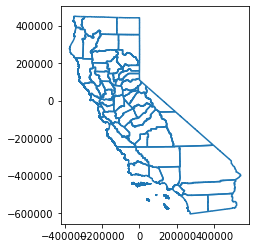

In [7]:
counties_df.plot()

#### Incorporated Cities data (~5MB)

In [8]:
cities_df = gpd.read_file(INCORP_CITIES_PATH, layer=0)
cities_df

,NAME,Shape_Length,Shape_Area,geometry
0,Adelanto,98980.479293,1.368904e+08,"MULTIPOLYGON (((244183.328 -378491.781, 244046..."
1,Agoura Hills,24495.413379,2.024990e+07,"MULTIPOLYGON (((117176.660 -426751.935, 117176..."
2,Alameda,46302.603534,2.769065e+07,"MULTIPOLYGON (((-197808.637 -27477.304, -19771..."
3,Albany,13499.800969,4.605202e+06,"MULTIPOLYGON (((-200911.170 -10739.993, -20090..."
4,Alhambra,20978.233054,1.976582e+07,"MULTIPOLYGON (((173339.612 -432761.068, 173617..."
...,...,...,...,...
478,Yountville,14224.355974,3.855351e+06,"MULTIPOLYGON (((-205961.697 46376.062, -205825..."
479,Yreka,48717.698415,2.585892e+07,"MULTIPOLYGON (((-215471.166 419674.952, -21546..."
480,Yuba City,64713.349052,3.679596e+07,"MULTIPOLYGON (((-144942.862 125550.424, -14486..."
481,Yucaipa,55683.494163,7.336180e+07,"MULTIPOLYGON (((276073.756 -433247.754, 276082..."


<AxesSubplot:>

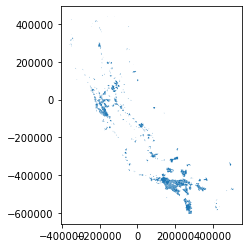

In [9]:
cities_df.plot()

### Clean Data

In [10]:
def print_col_info(df, max_out=5):
    # iterate over each column
    for col_name, col in df.items():
        if col_name == 'geometry':
            print(f"""Column name: {col_name}, NaN count: {col.isna().sum()}""")
            continue
        if len(col.value_counts()) <= max_out: 
            print(f"""Column name: {col_name}, NaN count: {col.isna().sum()}, 
            # of non-null values: {len(col.value_counts(dropna=False))}, 
            distinct values: {col.value_counts().index.tolist()}""")
        else: 
            print(f"""Column name: {col_name}, NaN count: {col.isna().sum()}, 
            # of non-null values: {len(col.value_counts(dropna=False))}""")
            
# First, we get some info about the fires_df itself
print("BEFORE CLEAINING:")
print()
print(f"There are {len(fires_df)} rows and {len(fires_df.columns)} columns.")
print(f"List of all column names: {fires_df.columns}")

# get more info about the columns themselves (all)
print_col_info(fires_df)

BEFORE CLEAINING:



NameError: name 'fires_df' is not defined

In [ ]:
# convert to datetime; null values are set to NaT
fires_df.ALARM_DATE = pd.to_datetime(fires_df.ALARM_DATE.str.strip('T00:00:00+00:00'), errors='coerce')
fires_df.CONT_DATE = pd.to_datetime(fires_df.CONT_DATE.str.strip('T00:00:00+00:00'), errors='coerce')

fires_df = fires_df.loc[fires_df.YEAR_.notna()] # drop rows w/o a specified year
fires_df.YEAR_ = pd.to_numeric(fires_df.YEAR_, downcast='float') # convert from object
fires_df = fires_df.loc[fires_df.YEAR_ >= 1950] # drop rows before 1950
fires_df.YEAR_ = pd.to_datetime(fires_df.YEAR_, format='%Y') # convert to datetime

fires_df = fires_df.loc[fires_df.CAUSE.notna()]
fires_df = fires_df.loc[fires_df.GIS_ACRES.notna()]
fires_df.OBJECTIVE = fires_df.OBJECTIVE.fillna(0)

In [47]:
# compare provided area (in acres) colulmns
print(fires_df[['REPORT_AC', 'GIS_ACRES']].head())
print()
print(fires_df[['REPORT_AC', 'GIS_ACRES']].tail())
fires_df.drop(columns=['REPORT_AC'], inplace=True)
print('REPORT_AC dropped')

   REPORT_AC   GIS_ACRES
0      110.0  109.602501
1      670.0  685.585022
2       26.0   27.300480
3       13.0   12.931550
4       10.3   10.315960

       REPORT_AC    GIS_ACRES
21312        NaN    42.282562
21314        NaN     8.482671
21315        NaN    64.888229
21316        NaN    66.587181
21317     8799.0  8799.325195
REPORT_AC dropped


In [48]:
print("AFTER CLEANING:")
print()
print_col_info(fires_df)

AFTER CLEANING:

Column name: YEAR_, NaN count: 0, 
            # of non-null values: 71
Column name: ALARM_DATE, NaN count: 1610, 
            # of non-null values: 6830
Column name: CONT_DATE, NaN count: 7489, 
            # of non-null values: 4479
Column name: CAUSE, NaN count: 0, 
            # of non-null values: 18
Column name: GIS_ACRES, NaN count: 0, 
            # of non-null values: 16003
Column name: C_METHOD, NaN count: 7329, 
            # of non-null values: 9
Column name: OBJECTIVE, NaN count: 0, 
            # of non-null values: 3, 
            distinct values: [1.0, 2.0, 0.0]
Column name: Shape_Length, NaN count: 0, 
            # of non-null values: 16010
Column name: Shape_Area, NaN count: 0, 
            # of non-null values: 16010
Column name: geometry, NaN count: 0


In [51]:
fires_df.YEAR_.value_counts().index.tolist()

2017-01-01    607
2020-01-01    499
2008-01-01    432
2018-01-01    410
1979-01-01    366
             ... 
1962-01-01    109
1971-01-01    109
1991-01-01     88
1963-01-01     79
1965-01-01     62
Name: YEAR_, Length: 71, dtype: int64

<AxesSubplot:>

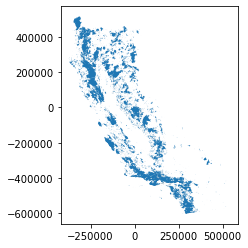

In [26]:
# fires_df = fires_df.loc[fires_df.ALARM_DATE.notna()]
fires_df.plot()

In [32]:
fires_df.CAUSE.value_counts()

14.0    9543
1.0     3454
9.0     3379
2.0     1246
7.0      903
5.0      723
10.0     454
11.0     412
4.0      380
3.0      342
8.0      196
18.0      90
6.0       80
15.0      21
19.0      17
16.0      14
13.0      11
12.0       5
Name: CAUSE, dtype: int64

In [27]:
pfires_df

,YEAR_,STATE,AGENCY,UNIT_ID,TREATMENT_ID,TREATMENT_NAME,TREATMENT_TYPE,START_DATE,END_DATE,TREATED_AC,GIS_ACRES,RX_CONSUM,PRE_CON_CLASS,POST_CON_CLASS,Shape_Length,Shape_Area,geometry
0,2020,CA,CDF,AEU,10509,Jan 31 2020 Broadcast,3.0,2020-01-31T00:00:00+00:00,2020-01-31T00:00:00+00:00,15.0,15.047045,NaN,NaN,NaN,1365.887529,6.089322e+04,"MULTIPOLYGON (((-45261.902 81865.442, -45248.3..."
1,2020,CA,PVT,AEU,10572,2020 Fuels Reduction,3.0,2020-02-13T00:00:00+00:00,2020-02-13T00:00:00+00:00,22.3,36.739716,NaN,NaN,NaN,2681.610336,1.486803e+05,"MULTIPOLYGON (((-57222.192 98500.043, -57231.6..."
2,2020,CA,CDF,AEU,10630,Feb 2020 Broadcast,3.0,2020-02-13T00:00:00+00:00,2020-02-18T00:00:00+00:00,22.4,38.839848,NaN,NaN,NaN,3918.219956,1.571792e+05,"MULTIPOLYGON (((-49821.237 54143.575, -49815.4..."
3,2020,CA,CDF,AEU,10639,Feb 2020 Broadcast,3.0,2020-02-11T00:00:00+00:00,2020-02-20T00:00:00+00:00,75.5,75.502464,NaN,NaN,NaN,3918.834462,3.055300e+05,"MULTIPOLYGON (((-47052.539 80922.773, -47052.5..."
4,2020,CA,CDF,AEU,10780,Mar 3 2020 Broadcast,3.0,2020-03-03T00:00:00+00:00,2020-03-03T00:00:00+00:00,61.8,61.773609,NaN,NaN,NaN,2769.034316,2.499805e+05,"MULTIPOLYGON (((-47591.189 80696.956, -47590.2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6407,2019,CA,CDF,BEU,9011,Rock Springs VMP,3.0,2019-06-17T00:00:00+00:00,2019-06-17T00:00:00+00:00,6.0,4410.436035,NaN,NaN,NaN,43918.799708,1.784839e+07,"MULTIPOLYGON (((-83812.469 -167644.628, -83812..."
6408,2019,CA,CDF,BEU,9011,Rock Springs VMP,3.0,2019-11-14T00:00:00+00:00,2019-11-19T00:00:00+00:00,4404.0,4410.436035,NaN,NaN,NaN,43918.799708,1.784839e+07,"MULTIPOLYGON (((-83812.469 -167644.628, -83812..."
6409,2019,CA,OTH,BEU,9874,Impact Burn,3.0,2019-05-01T00:00:00+00:00,2019-06-01T00:00:00+00:00,1728.0,1728.423584,NaN,NaN,NaN,12837.895799,6.994679e+06,"MULTIPOLYGON (((-68525.876 -241585.362, -68522..."
6410,2019,CA,CDF,SLU,10270,Webster Burning,3.0,2019-11-12T00:00:00+00:00,2019-12-31T00:00:00+00:00,131.0,131.035889,NaN,NaN,NaN,6110.293336,5.302832e+05,"MULTIPOLYGON (((-48329.776 -282952.083, -48320..."


In [28]:
npfires_df

,TREATMENT_ID,TREATMENT_NAME,TREATMENT_TYPE,UNIT_ID,AGENCY,TREATED_AC,GIS_ACRES,STATE,YEAR_,RX_CONSUM,PRE_CON_CLASS,POST_CON_CLASS,END_DATE,START_DATE,Shape_Length,Shape_Area,geometry
0,3277604,NON_WUI,13,SQF,USF,136.388878,136.388840,CA,2006,NaN,NaN,NaN,2006-04-15T00:00:00+00:00,None,7391.270964,5.519460e+05,"MULTIPOLYGON (((134082.716 -211654.937, 134097..."
1,3277608,NON_WUI,15,SQF,USF,292.127163,292.126648,CA,2006,NaN,NaN,NaN,2006-07-03T00:00:00+00:00,None,17166.848106,1.182195e+06,"MULTIPOLYGON (((92373.011 -136235.723, 92392.4..."
2,3277612,SOUTHRIDGE 1-1 CHIP,5,BDF,USF,4.726939,4.726954,CA,2006,NaN,NaN,NaN,2006-02-01T00:00:00+00:00,None,880.091816,1.912930e+04,"MULTIPOLYGON (((305859.984 -470029.721, 305847..."
3,3277613,SOUTHRIDGE UNIT 5 CUT AND STACK,9,BDF,USF,22.742776,22.742844,CA,2006,NaN,NaN,NaN,2006-03-01T00:00:00+00:00,None,1623.896026,9.203702e+04,"MULTIPOLYGON (((305354.249 -471295.580, 305378..."
4,3277840,HIGHWAY 20 CUT & PILING (06),9,TNF,USF,106.348339,106.347382,CA,2006,NaN,NaN,NaN,2006-09-15T00:00:00+00:00,None,3002.279795,4.303726e+05,"MULTIPOLYGON (((-68800.396 144860.457, -68779...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,6284819,1_WCF_Pile_RX_14,10,NOD,BLM,20.000000,23.070789,CA,2013,NaN,NaN,NaN,2013-12-09T00:00:00+00:00,2013-12-05T00:00:00+00:00,2171.144137,9.336417e+04,"MULTIPOLYGON (((-238374.513 302862.162, -23844..."
860,6279834,1_Hayden Hill,10,NOD,BLM,75.000000,75.690201,CA,2013,NaN,NaN,NaN,2013-10-31T00:00:00+00:00,2013-10-30T00:00:00+00:00,2869.362371,3.063074e+05,"MULTIPOLYGON (((-79147.701 324730.033, -79156...."
861,None,Bald Hills Shaded Fuel Break,10,RNP,NPS,22.232445,22.232445,CA,2014,NaN,NaN,NaN,None,None,4395.686454,8.997152e+04,"MULTIPOLYGON (((-330229.682 359566.978, -33025..."
862,2621,Warenella fuebreak,10,LNU,CDF,41.000000,83.849998,CA,2015,NaN,NaN,NaN,None,2014-12-15T00:00:00+00:00,28213.609424,3.393272e+05,"MULTIPOLYGON (((-191424.441 -100961.322, -1914..."


## Objective feature:
* 0 = null value
* 1 = suppression (Wildfire)
* 2 = resource benefit (WFU)

### Suppression ([source1](https://www.nwcg.gov/term/glossary/suppression) and [source2](https://www.fws.gov/fire/what_we_do/wildfire.shtml)):
    Suppression: All the work to extinguish or limit wildland fire spread.
    
    Wildfire is an unplanned wildland fire, either natural or human-caused.
    
    The primary objective of fighting unwanted wildfire is to protect human life. Public and firefighter safety is the first priority and is not compromised for any reason. Protecting communities, property, and natural resources are secondary objectives after ensuring human safety.
    
### Resource benefit ([source](https://www.fws.gov/fire/what_we_do/wildland_fire_use.shtml)):
    Wildland fire use (WFU) is the management of naturally ignited wildland fires (those started by lightning or lava) to accomplish specific resource objectives within a pre-defined area. Objectives can include maintenance of healthy forests, rangelands, and wetlands, and support of ecosystem diversity.

    In some cases, when outlined in a fire management plan and where communities are not at risk, allowing natural fires to burn may be the most appropriate management response. In rugged, steep, or highly inaccessible terrain where people are not threatened, wildland fire use can help avoid putting firefighters at unreasonable risk.

## Cause feature: 
    The nine general causes used in the U.S. are lightning, campfire, smoking, debris burning, incendiary, machine use (equipment), railroad, children, and miscellaneous.
([source](https://www.nwcg.gov/term/glossary/fire-cause)] <br>

Click on respective cause for [NWCG glossary](https://www.nwcg.gov/glossary/a-z) definition:
* [Lightning](https://www.nwcg.gov/term/glossary/lightning-fire): 
* [Smoking](https://www.nwcg.gov/term/glossary/smoking-as-a-fire-cause)
* [Debris](https://www.nwcg.gov/term/glossary/debris-burning-fire)
* [Equipment Use](https://www.nwcg.gov/term/glossary/equipment-use-fire)
* [Railroad](https://www.nwcg.gov/term/glossary/railroad-fire)
* [Miscellaneous](https://www.nwcg.gov/term/glossary/miscellaneous-fire) <br> <br>
* [Arson](https://www.nwcg.gov/term/glossary/arson-fire)
* [Vehicle](https://www.nwcg.gov/term/glossary/vehicle-fire)
* [Structure](https://www.nwcg.gov/term/glossary/structure-fire)
* [Escaped Prescribed Burn](https://www.nwcg.gov/term/glossary/escaped-fire)

Omitted causes: 
* Campfire, Playing with Fire, Power Line, Firefighter Training, Non-Firefighter Training, Unknown/Unidentified, Aircraft, Volcanic, Illegal Alien Campfire

*Note: Arson != Structure (see each definition for more)*

In [49]:
cause_dict = {1: 'Lightning', 2: 'Equipment Use', 3: 'Smoking', 4: 'Campfire', 
             5: 'Debris', 6: 'Railroad', 7: 'Arson', 8: 'Playing with Fire', 
             9: 'Miscellaneous', 10: 'Vehicle', 11: 'Power Line', 
             12: 'Firefighter Training', 13: 'Non-Firefighter Training',
             14: 'Unknown/Unidentified', 15: 'Structure', 16: 'Aircraft', 
             17: 'Volcanic', 18: 'Escaped Prescribed Burn', 
             19: 'Illegal Alien Campfire'}

In [50]:
fires_df.CAUSE = fires_df.CAUSE.replace(cause_dict)
fires_df.CAUSE.value_counts()

Unknown/Unidentified        6620
Lightning                   2890
Miscellaneous               2013
Equipment Use               1226
Arson                        867
Debris                       518
Vehicle                      453
Power Line                   412
Campfire                     352
Smoking                      248
Playing with Fire            188
Escaped Prescribed Burn       90
Railroad                      76
Structure                     19
Illegal Alien Campfire        17
Aircraft                      14
Non-Firefighter Training      11
Firefighter Training           5
Name: CAUSE, dtype: int64

In [15]:
collect_meth_dict = {1: 'GPS Ground', 2: 'GPS Air', 3: 'Infrared',
                    4: 'Other Imagery', 5: 'Photo Interpretation',
                    6: 'Hand Drawn', 7: 'Mixed Collection Methods',
                    8: 'Unknown'}

In [16]:
objective_dict = {0: 'Unknown', 1: 'Suppression', 2: 'Resource Benefit'}

In [157]:
fires_df.ALARM_DATE.value_counts(dropna=False)

2008-06-21    121
2003-09-03     58
2015-07-03     55
1999-08-23     46
2008-06-02     44
             ... 
2000-09-29      1
1994-09-06      1
2006-05-14      1
1992-09-27      1
2000-05-29      1
Name: ALARM_DATE, Length: 3560, dtype: int64

### Feature: Year

In [158]:
"""
    Return subset series such that rows with a count less than x are removed 
"""
def prune_series(s_input, threshold):
    return s_input[s_input > threshold]

In [159]:
yrs = wf_perims['YEAR_']
# index series in order from oldest to recent
sort_yrs = yrs.value_counts().sort_index()
# find years with greater than x fires
sub_yrs = prune_series(sort_yrs, 100)

yrs_list = sub_yrs.astype(int).index.tolist()
print(type(yrs.index))
# check what years have gaps
last_rec_yr = int(yrs_list[0])
for i in range(1, len(yrs_list)):
    next_rec_yr = int(yrs_list[i])
    if next_rec_yr - last_rec_yr > 1: 
        print(f"Last yr: {last_rec_yr}, Curr yr: {next_rec_yr}")
    
    last_rec_yr = next_rec_yr

<class 'pandas.core.indexes.range.RangeIndex'>
Last yr: 1911, Curr yr: 1914
Last yr: 1924, Curr yr: 1926
Last yr: 1926, Curr yr: 1928
Last yr: 1932, Curr yr: 1934
Last yr: 1934, Curr yr: 1936
Last yr: 1936, Curr yr: 1939
Last yr: 1939, Curr yr: 1941
Last yr: 1947, Curr yr: 1949
Last yr: 1962, Curr yr: 1964
Last yr: 1964, Curr yr: 1966
Last yr: 1990, Curr yr: 1992


#### The fires_df has a consistent coverage from 1992-2020, so we will explore this subset first

In [41]:
fires_df[fires_df.STATE == 'AZ']

,YEAR_,STATE,AGENCY,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,REPORT_AC,GIS_ACRES,C_METHOD,OBJECTIVE,Shape_Length,Shape_Area,geometry
16954,2009-01-01,AZ,BLM,,2009-07-06,2009-07-21,14.0,NaN,330.160278,8.0,1.0,10661.468968,1.336111e+06,"MULTIPOLYGON (((518831.882 -418116.038, 518861..."


In [161]:
start_date = fires_df.ALARM_DATE.min() 
end_date = fires_df.ALARM_DATE.max()
fires_df.set_index('ALARM_DATE', inplace=True)

<AxesSubplot:>

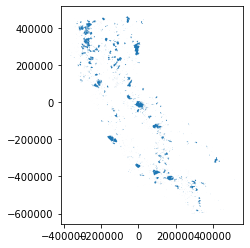

In [162]:
import matplotlib.pyplot as plt 

fires_df[start_date:end_date].plot()

In [171]:
fires_df = pd.fires_dfFrame(fires_df)
fires_df.groupby(fires_df.index)

In [167]:
xs = fires_df.index.unique()
fires_df.plot.scatter(x=xs, )

TypeError: scatter() missing 1 required positional argument: 'y'